In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root



# Code

In [3]:
#export
from functools import reduce

from typing import Union

from scipy import sparse
import numpy as np

from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline

from joblib import effective_n_jobs, Parallel, delayed

from sknetwork.clustering import KMeans, Louvain, PropagationClustering

from utils import hstack, sparse_dot_product
from preprocessing import RobustOneHotEncoder

In [4]:
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor

In [5]:
#session of variables to testing sessions
n_features = 7
cardinality_per_feature = 1000
n_classes = 5
n_reg_dims = 2


X = np.random.randint(0,cardinality_per_feature,(1000,n_features))

y_class = np.random.randint(0,n_classes, 1000)
y_reg = np.random.randn(1000,n_reg_dims)

In [6]:
#export
from sklearn.datasets import make_regression

def sigmoid(x):
    return 1/(1+np.exp(x))

def make_bimodal_assymetric_regression(
    n_samples=100000,
    bimodal_factor_weight = 2,
    n_features=15,
    n_informative=6,
    n_targets=2,
    bias=500,
    effective_rank=None,
    tail_strength=10,
    noise=150,
    shuffle=True,
    coef=False,
    random_state=None
):
    
    X,y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_targets=n_targets,
        bias=bias,
        effective_rank=effective_rank,
        tail_strength=tail_strength,
        noise=noise,
        shuffle=shuffle,
        coef=coef,
        random_state=random_state
    )


    #make one of X[1] feature mode weightening    
    bimodal_factors = (sigmoid(bimodal_factor_weight*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int)
    bimodal_factors[bimodal_factors == 0] = -1
    bimodal_factors = bimodal_factors.reshape(-1,1)

    y = bimodal_factors*y
    
    return X,y

In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression, make_blobs
import seaborn as sns

%matplotlib inline

X, y = make_classification(
    n_samples = 100_000,
    n_features = 3,
    n_informative = 3,
    n_redundant = 0,
    #bias = 10,
    #noise = 10,
    n_classes = 3,
    n_clusters_per_class = 2,
    hypercube = True,
)


blobs, labels = make_blobs(n_samples = 10_000,cluster_std = 3, n_features = 4)
#sns.scatterplot(*blobs.T, hue = labels)
#plt.show()

In [8]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

import plotly.io as pio
pio.renderers.default='iframe'

df = pd.DataFrame(X)
df.columns = [f'X{i}' for i in range(X.shape[-1])]
df['y'] = y.astype(str)

fig = px.scatter_3d(df, x='X0', y='X1', z='X2',
              color='y')
#fig.show()

#plt.cls()
#sns.scatterplot(*X.T[:2], hue = y)
#plt.show()

# ForestNeighbors

In [9]:
from ensemble import ForestNeighbors

In [11]:
clsf = RandomForestClassifier(100,max_depth = None, min_samples_leaf = 5, n_jobs = -1)
fn = ForestNeighbors(clsf, prefit_forest_estimator = False, n_jobs = 1).fit(X,y)

/home/alan/Desktop/git_projects/heterogeneous-metric-learning/hml/ensemble.py:207: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [12]:
%timeit fn.kneighbors(n_jobs = -1, sample_size = 1000)
%timeit fn.kneighbors(n_jobs = -1, sample_size = None)

22.2 s ± 546 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
39.6 s ± 679 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Forest space partitioning

In [13]:
from ensemble import MixedForestRegressor

In [14]:
from scipy.stats import entropy

mxfc = MixedForestRegressor(
    [ExtraTreesClassifier(10, min_samples_leaf = 1,n_jobs = -1),RandomForestClassifier(10, min_samples_leaf = 10, n_jobs = -1)],
    [1,10],
    embedding_method='kmeans',
    fully_supervised = False, 
    biadjecency_weights = 'weighted',
    #resolution = 1,
    n_clusters = 100
    
).fit(X,y)


embeddings = mxfc.transform(X).A
clusters = np.argmax(embeddings, 1)

#sns.scatterplot(X[:,0], X[:,1], hue = clusters, palette = 'tab20')
#sns.scatterplot(X[:,1], X[:,2], hue = embeddings.max(1) <.5)

np.unique(clusters, return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([4265, 3913, 3037, 2904, 1806, 1961, 1965, 2007, 1943, 1891, 1853,
        1683, 1673, 1642, 1696, 1601, 1588, 1582, 1488, 1389, 1379, 1181,
        1238, 1220, 1182, 1172, 1089, 1089, 1044, 1065, 1080, 1024, 1045,
         962,  961,  934,  912,  919,  938,  960,  938,  927,  867,  797,
         809,  844,  817,  796,  848,  827,  799,  786,  762,  775,  787,
         800,  743,  786,  760,  751,  712,  735,  745,  709,  699,  672,
         659,  667,  645,  638,  583,  637,  601,  603,  578,  593,  584,
         548,  550,  565,  559, 

In [15]:
#df['cluster'] = clusters
#df['max_proba'] = embeddings.max(1)
#px.scatter_3d(df, 'X0', 'X1', 'X2', color = 'y', symbol = 'cluster', size = 'max_proba')

/home/alan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/alan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/alan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

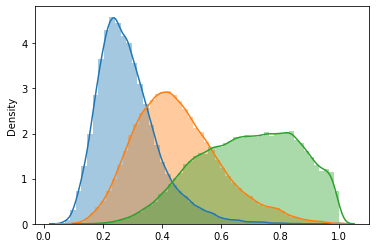

In [16]:
sns.distplot(mxfc.transform(X, alpha = .25).max(1).data)
sns.distplot(mxfc.transform(X, alpha = .5).max(1).data)
sns.distplot(mxfc.transform(X, alpha = 1).max(1).data)

/home/alan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(5.880795367909377, 11.050541242107075)

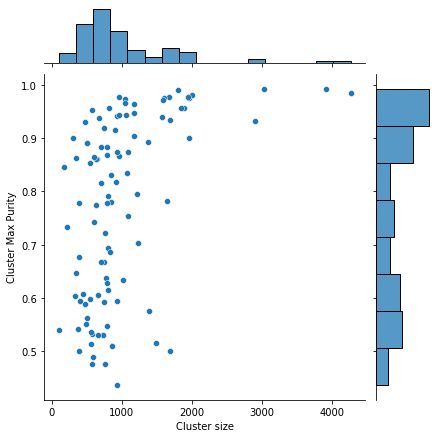

In [17]:
entropies = []
sizes = []
proportion_class = []
for c in np.unique(clusters):
    msk = clusters == c
    entropies.append(entropy(y[msk]))
    sizes.append(msk.sum())
    proportion_class.append(pd.Series(y[msk]).value_counts(1).max())

#jnt = sns.jointplot(sizes, entropies)
jnt = sns.jointplot(sizes, proportion_class)
jnt.ax_joint.set_xlabel('Cluster size')
jnt.ax_joint.set_ylabel('Cluster Max Purity')
np.array(entropies).mean(),entropy(y)

In [18]:
from ensemble import MixedForestEmbedder, HeterogeneousMixedForest, LeafEmbedder

In [19]:
from ensemble import CustomLGBMClassifier, CustomLGBMRegressor

In [20]:
bpt = LeafEmbedder(
    CustomLGBMClassifier(n_estimators = 100, min_samples_leaf = 1),
    embedding_method='kmeans',
    n_clusters = 30,
    ensemble_node_weights_attr="node_weights_"
).fit(X,y)


embeddings = bpt.transform(X).A
clusters = np.argmax(embeddings, 1)

#sns.scatterplot(X[:,0], X[:,1], hue = clusters, palette = 'tab20')
#sns.scatterplot(X[:,1], X[:,2], hue = embeddings.max(1) <.5)

np.unique(clusters, return_counts = True)

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([12876, 10727,  9128,  8319,  5425,  7120,  1475,  6782,  4460,
         5686,  2031,  5135,  1617,  2008,  1805,  1357,  2105,  2213,
         1927,   371,   905,   460,  1402,   750,     2,  1182,  1385,
            8,  1287,    52]))

/home/alan/.local/lib/python3.8/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning:

invalid value encountered in true_divide

/home/alan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(nan, 11.050541242107075)

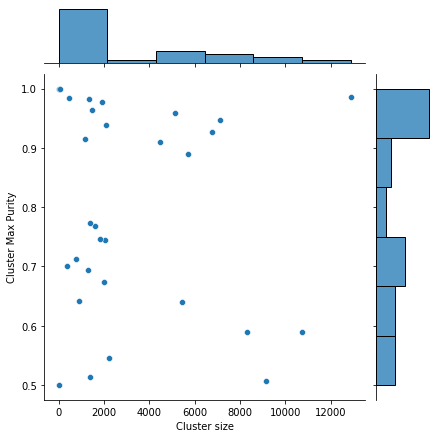

In [21]:
entropies = []
sizes = []
proportion_class = []
for c in np.unique(clusters):
    msk = clusters == c
    entropies.append(entropy(y[msk]))
    sizes.append(msk.sum())
    proportion_class.append(pd.Series(y[msk]).value_counts(1).max())

#jnt = sns.jointplot(sizes, entropies)
jnt = sns.jointplot(sizes, proportion_class)
jnt.ax_joint.set_xlabel('Cluster size')
jnt.ax_joint.set_ylabel('Cluster Max Purity')
np.array(entropies).mean(),entropy(y)

In [22]:
df['cluster'] = clusters
df['max_proba'] = embeddings.max(1)
px.scatter_3d(df, 'X0', 'X1', 'X2', color = 'y', symbol = 'cluster', size = 'max_proba')

In [34]:
class ArchetypeClassifier(BaseEstimator):
    def __init__(
        self,
        base_embedder,
        final_transformer,
        prefit_embedder = False,
        use_membership_weights = True,
    ):
        
        """
        An abstract estimator that applies some transformation
        on data that has a fuzzy membership to a given cluster (or archetype)

        The fit and transform/predict/... processes in each archetype are performed 
        only in the subset of data that has a positive probability of belonging to that
        cluster. Then, the individual weight of each data point is given by the membership score of that
        point. If user defined sample_weight is passed, the final weights during train is the product
        of both membership scores and sample_weight
        """

        self.base_embedder = base_embedder
        self.final_transformer = final_transformer
        self.prefit_embedder = prefit_embedder
        self.use_membership_weights = use_membership_weights
        return

    def fit(self, X, y = None, sample_weight = None, **kwargs):
        
        if not self.prefit_embedder:
            base_embedder = clone(self.base_embedder)
            base_embedder.fit(X, y=y, sample_weight=sample_weight)
        else:
            base_embedder = clone(self.base_embedder)
        
        memberships = base_embedder.transform(X)
        if (memberships.sum(axis = 1) != 1).any():
            raise ValueError(f"Some membership rows do not sum up to 1")
        
        n_archetypes = memberships.shape[-1]
        archetype_estimator_list = []
        for i in range(n_archetypes):
            estim = clone(self.final_transformer)
            X_sample, y_sample, weights, mask = self._get_subset_and_weights(
                X=X,
                y=y,
                membership=memberships[:,i],
                sample_weight = sample_weight,
                use_membership_weights = self.use_membership_weights
            )
            
            if not weights is None:
                estim.fit(X=X_sample, y=y_sample, sample_weight=weights)
            else:
                #to ensure will work with estimators that donnot accept sample_weight parameters in fit
                estim.fit(X=X_sample, y=y_sample)
            
            archetype_estimator_list.append(estim)
        
        #save states
        self.archetype_estimator_list_ = archetype_estimator_list
        self.base_embedder_ = base_embedder
        self.n_archetypes_ = n_archetypes
        return self
    
    
    def _get_subset_and_weights(self, X, y, membership, sample_weight, use_membership_weights):
        """
        returns data instances and sample weights for membership > 0
        """
        mask = membership > 0
        X_sample = X[mask]
        
        if not y is None:
            y_sample = y[mask]
        else:
            y_sample = None
        

        if sample_weight is None:
            if use_membership_weights:
                weights = membership[mask]
            else:
                weights = None
        else:
            if use_membership_weights:
                weights = sample_weight[mask]*membership[mask]
            else:
                weights = sample_weight[mask]
        
        return X_sample, y_sample, weights, mask
    
    def _infer_matrix(self, infer_method, X, **kwargs):
        
        
        memberships = self.base_embedder_.transform(X)
        if (memberships.sum(axis = 1) != 1).any():
            raise ValueError(f"Some membership rows do not sum up to 1")
        
        results  = []
        for i in range(len(self.base_embedder_.classes_)):            
            results.appends(
                parse.lil_matrix((X.shape[0], self.n_archetypes_), dtype=np.float32))
        
        res = getattr(estim, infer_method)(X, **kwargs)
        for i in range(self.n_archetypes_):
            estim = self.archetype_estimator_list_[i]
            X_sample, y_sample, weights, mask = self._get_subset_and_weights(
                X=X,
                y=None,
                membership=memberships[:,i],
                sample_weight = None,
                use_membership_weights = self.use_membership_weights
            )
            res = getattr(estim, infer_method)(X, **kwargs)
            
            class_idxs = self._get_estim_classes_index(estim)
            for j in range(len(class_idxs)):
                #one sprse matrix per class
                results[class_idxs[j]][mask,i] = res[:,j]
                                        
        return results

    def _infer_reduce(self, infer_method, X, **kwargs):
        
        memberships = self.base_embedder_.transform(X)
        if (memberships.sum(axis = 1) != 1).any():
            raise ValueError(f"Some membership rows do not sum up to 1")
                        
        results  = []
        for i in range(len(self.base_embedder_.classes_)):            
            results.appends(
                parse.lil_matrix((X.shape[0], self.n_archetypes_), dtype=np.float32))
        
        for i in range(self.n_archetypes_):
            estim = self.archetype_estimator_list_[i]
            X_sample, y_sample, weights, mask = self._get_subset_and_weights(
                X=X,
                y=None,
                membership=memberships[:,i],
                sample_weight = None,
                use_membership_weights = self.use_membership_weights
            )
            
            res = getattr(estim, infer_method)(X, **kwargs)
            
            if not weights is None:
                res = res*weights
            else:
                pass
            
            class_idxs = self._get_estim_classes_index(estim)
            for j in range(len(class_idxs)):
                #one sprse matrix per class
                results[class_idxs[j]][mask,i] = res[:,j]                    
            
        #reduce to weighted average of class proba in each archetype
        results = np.hstack([r.sum(1) for r in results])
        return results
    
    def _get_estim_classes_index(self, estim):        
        indexes = np.isin(self.base_embedder_.classes_, estim.classes_).nonzero()[0]
        return indexes
        
        

array([0, 3])